# Exploratory Analysis
This notebook just contains misc data exploring.
Run the snakemake workflow prior to this notebook.

In [2]:
DATA_DIR = "/home/jack/unm_gra/data/LAA/Homosapiens-SINGLEPROTEIN-1100"

## Setup

In [3]:
import polars as pl
import os
import seaborn as sns
import matplotlib.pyplot as plt

## Plot Promiscuity Degree (PD) Data
Promiscuity Degree = Number of unique targets a given ligand (i.e., compound) was active against. This is the same definition used in https://pubs.acs.org/doi/10.1021/acsomega.8b02998

In [4]:
activity_df = pl.read_csv(os.path.join(DATA_DIR, "activities", "activity_info.tsv"), separator="\t")
assay_df = pl.read_csv(os.path.join(DATA_DIR, "assays", "assay_info.tsv"), separator="\t")

In [5]:
joined = activity_df.join(assay_df, on="assay_id", how="inner")
mol2tid_df = joined.select(["molregno", "tid"]).unique()
pd_df = (
    mol2tid_df
    .group_by("molregno")
    .agg(pl.count("tid").alias("promiscuity_degree"))
)

<Axes: xlabel='promiscuity_degree', ylabel='Count'>

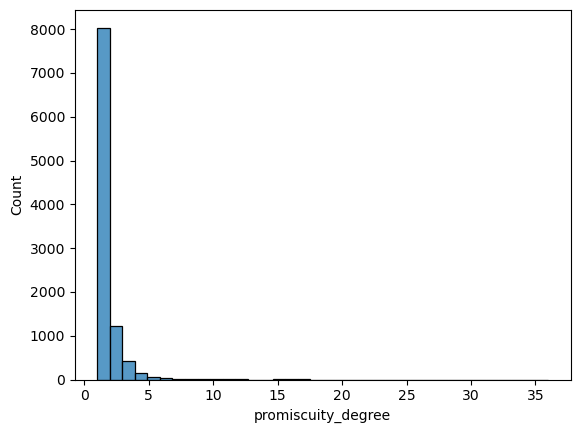

In [6]:
sns.histplot(pd_df, x="promiscuity_degree", bins=max(pd_df["promiscuity_degree"]))

In [7]:
breaks = [1, 4]
labels = ["1", "2-4", "≥5"]
pd_df = pd_df.with_columns(pl.col("promiscuity_degree").cut(breaks=breaks, labels=labels).alias("PD_bin"))
bin_counts = pd_df["PD_bin"].value_counts(sort=False)
bin_counts

PD_bin,count
cat,u32
"""1""",8036
"""2-4""",1803
"""≥5""",156


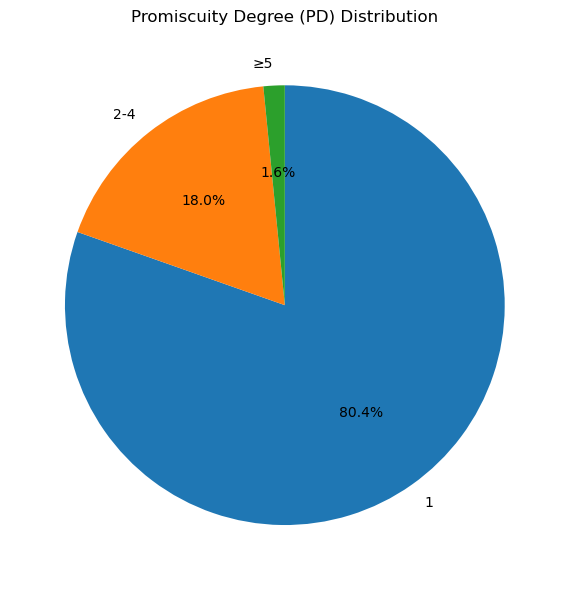

In [8]:
pie_labels, pie_counts = bin_counts["PD_bin"], bin_counts["count"]
plt.figure(figsize=(6, 6))
plt.pie(
    pie_counts,
    labels=pie_labels,
    autopct='%1.1f%%',
    startangle=90, 
    counterclock=False
)
plt.title("Promiscuity Degree (PD) Distribution")
plt.tight_layout()
plt.show()

## KinMap Visualizations
Gathering info on number of assays, number of unique active compounds for KinMap
visuals.
http://www.kinhub.org/kinmap/

*Note*: To download KinMap images you have to select "SVG" and then edit the data using the fix here: https://askubuntu.com/a/1265209 

In [9]:
def prepare_kinmap_df_with_bins(
    df: pl.DataFrame,
    colname: str,
    cutoffs: list[int],
    colors: list[str],
    min_size: int = None, 
    max_size: int = None  # Optional cap on 'size'
) -> pl.DataFrame:
    """
    Prepares a KinMap visualization DataFrame.

    Parameters:
        df: Input DataFrame with at least 'xName' and the specified `colname`.
        colname: Name of the numeric column to use for binning and size.
        cutoffs: List of upper bounds for the bins (must be increasing).
        colors: List of colors, must be len(cutoffs) + 1.
        min_size: Optional minimum value on the 'size' column (e.g., 100 for visualization).
        max_size: Optional cap on the 'size' column (e.g., 100 for visualization).

    Returns:
        A DataFrame with columns: xName, size, fill.
    """
    if len(colors) != len(cutoffs) + 1:
        raise ValueError("Number of colors must be one more than number of cutoffs.")

    col = pl.col(colname)

    # Construct fill color expression based on cutoffs
    expr = pl.when(col < cutoffs[0]).then(pl.lit(colors[0]))
    for i in range(1, len(cutoffs)):
        expr = expr.when(col < cutoffs[i]).then(pl.lit(colors[i]))
    expr = expr.otherwise(pl.lit(colors[-1]))

    # Optional size cap
    max_size = df[col].max() if max_size is None else max_size
    min_size = df[col].min() if min_size is None else min_size
    size_expr = pl.when(col < max_size).then(col).otherwise(max_size)
    size_expr = pl.when(col < min_size).then(pl.when(col == 0).then(0).otherwise(min_size)).otherwise(size_expr)

    return df.select([
        pl.col("xName"),
        size_expr.alias("size"),
        expr.alias("fill")
    ])

In [10]:
kinmap_df = pl.read_csv("../data/kinmap_file.tsv", separator="\t", columns=["xName", "UniprotID"])
kinmap_df = kinmap_df.unique(subset=["UniprotID"])

In [11]:
assert not(kinmap_df["xName"].is_duplicated().any())

In [12]:
chembl_target_df = pl.read_csv("/home/jack/unm_gra/data/LAA/Homosapiens-SINGLEPROTEIN-1100/targets/target_info.tsv", separator="\t", columns=["accession", "tid"])
chembl_target_df = chembl_target_df.rename({"accession": "UniprotID"})
chembl_target_df = chembl_target_df.unique(subset=["UniprotID"]) # currently there are duplicates bc some targets are assigned to multiple different families

In [13]:
ktarget_df = kinmap_df.join(chembl_target_df, on="UniprotID", how="inner")

In [14]:
ktarget_df.head()

xName,UniprotID,tid
str,str,i64
"""BIKE""","""Q9NSY1""",30042
"""CCRK""","""Q8IZL9""",109745
"""Erk4""","""P31152""",101538
"""BRK""","""Q13882""",30026
"""SgK288""","""Q8NFD2""",101226


In [15]:
tid2assaycount_df = (
    assay_df
    .group_by("tid")
    .agg(pl.count("assay_id").alias("n_assays"))
)

In [16]:
tid2ligandcount_df = (
    mol2tid_df
    .group_by("tid")
    .agg(pl.count("molregno").alias("n_ligands"))
)

In [17]:
ktarget_df = ktarget_df.join(tid2assaycount_df, on="tid", how="left")
ktarget_df = ktarget_df.with_columns(ktarget_df["n_assays"].fill_null(0))

In [18]:
ktarget_df = ktarget_df.join(tid2ligandcount_df, on="tid", how="left")
ktarget_df = ktarget_df.with_columns(ktarget_df["n_ligands"].fill_null(0))

In [19]:
ktarget_df

xName,UniprotID,tid,n_assays,n_ligands
str,str,i64,u32,u32
"""BIKE""","""Q9NSY1""",30042,69,20
"""CCRK""","""Q8IZL9""",109745,3,0
"""Erk4""","""P31152""",101538,21,0
"""BRK""","""Q13882""",30026,144,12
"""SgK288""","""Q8NFD2""",101226,21,0
…,…,…,…,…
"""CaMK2g""","""Q13555""",30002,94,1
"""NEK6""","""Q9HC98""",30038,141,0
"""CaMK4""","""Q16566""",10971,154,0


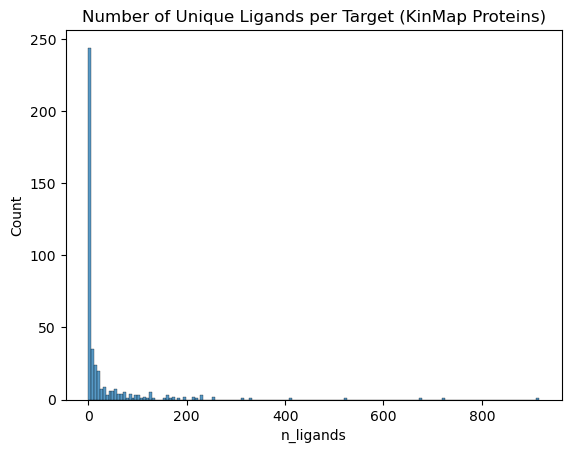

In [20]:
sns.histplot(ktarget_df, x="n_ligands")
plt.title("Number of Unique Ligands per Target (KinMap Proteins)")
plt.show()

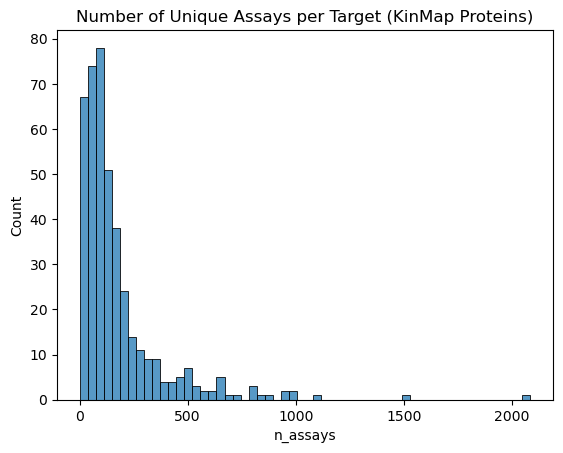

In [21]:
sns.histplot(ktarget_df, x="n_assays")
plt.title("Number of Unique Assays per Target (KinMap Proteins)")
plt.show()

In [22]:
def create_kinmap_csv(df: pl.DataFrame, col: str, size_cutoffs: list, colors: list, save_pth: str):
    # just fixing size for easier vis
    kinmap_csv_df = prepare_kinmap_df_with_bins(df, col, size_cutoffs, colors, max_size=15, min_size=15)
    kinmap_csv_df.write_csv(save_pth)

In [23]:
# save n_assay data
size_cutoffs = [5, 50, 100]
colors = sns.color_palette("viridis", len(size_cutoffs) + 1).as_hex() # maps sizes to color
print(colors)
pth = "/home/jack/unm_gra/data/LAA/Homosapiens-SINGLEPROTEIN-1100/addl_files/kinmap_nassay_vis.csv"
create_kinmap_csv(ktarget_df, "n_assays", size_cutoffs, colors, pth)

['#414487', '#2a788e', '#22a884', '#7ad151']


In [24]:
# save n_ligand data
size_cutoffs = [5, 50, 100] # 1-4, 5-49, 50-99, 100+
colors = sns.color_palette("viridis", len(size_cutoffs) + 1).as_hex() # maps sizes to color
pth = "/home/jack/unm_gra/data/LAA/Homosapiens-SINGLEPROTEIN-1100/addl_files/kinmap_nligand_vis.csv"
create_kinmap_csv(ktarget_df, "n_ligands", size_cutoffs, colors, pth)

In [25]:
# save main df
ktarget_df.write_csv("/home/jack/unm_gra/data/LAA/Homosapiens-SINGLEPROTEIN-1100/addl_files/kinmap_data.csv")

## Looking at ligands in class_level=4

In [26]:
class_level = 4
cluster_df = pl.read_csv(f"/home/jack/unm_gra/data/LAA/Homosapiens-SINGLEPROTEIN-1100/ligand_clusters/ligand2cluster-class_level={class_level}.tsv", separator="\t")

In [27]:
family_info_df = pl.read_csv("/home/jack/unm_gra/data/LAA/Homosapiens-SINGLEPROTEIN-1100/targets/family_addl_info.tsv", separator="\t")

In [28]:
cluster_df = cluster_df.join(family_info_df, on="protein_class_id")
cluster_df

molregno,tid,protein_class_id,fam_cluster,parent_id,pref_name,short_name,class_level
i64,i64,i64,i64,i64,str,str,i64
148,10044,158,2,1100,"""Other protein kinase group""","""Other""",4
213,10197,148,1,1100,"""CMGC protein kinase group""","""Cmgc""",4
213,10839,1339,8,1100,"""CAMK protein kinase group""","""Camk""",4
213,12944,1289,4,1100,"""AGC protein kinase group""","""Agc""",4
213,11843,1339,8,1100,"""CAMK protein kinase group""","""Camk""",4
…,…,…,…,…,…,…,…
2881289,30014,148,1,1100,"""CMGC protein kinase group""","""Cmgc""",4
2881289,30036,148,1,1100,"""CMGC protein kinase group""","""Cmgc""",4
2881289,12090,148,1,1100,"""CMGC protein kinase group""","""Cmgc""",4


In [29]:
def pie_bar_plot(pl_counts, x: str, y: str, bar_title: str, pie_title: str, xlabel: str, ylabel: str):
    # Set up the plotting style
    plt.style.use('default')

    # Option 1: Side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Bar chart
    colors = sns.color_palette("hls", len(pl_counts))
    sns.barplot(data=pl_counts, x=x, y=y, ax=ax1, palette=colors)
    ax1.set_title(bar_title, fontsize=14, fontweight='bold')
    ax1.set_xlabel(xlabel, fontsize=12)
    ax1.set_ylabel(ylabel, fontsize=12)

    # Add value labels on bars
    m = pl_counts[y].max()
    for i, v in enumerate(pl_counts[y]):
        ax1.text(i, v + m * 0.01, 
                str(v), ha='center', va='bottom', fontweight='bold')

    # Pie chart
    wedges, texts, autotexts = ax2.pie(pl_counts[y], 
                                    labels=pl_counts[x],
                                    autopct='%1.1f%%',
                                    colors=colors,
                                    startangle=90)

    ax2.set_title(pie_title, fontsize=14, fontweight='bold')

    # Enhance pie chart text
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("Summary of distribution:")
    print(pl_counts)
    print(f"Average {y} per {x}: {pl_counts[y].mean():.1f}")

/tmp/ipykernel_97248/2170470282.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pl_counts, x=x, y=y, ax=ax1, palette=colors)


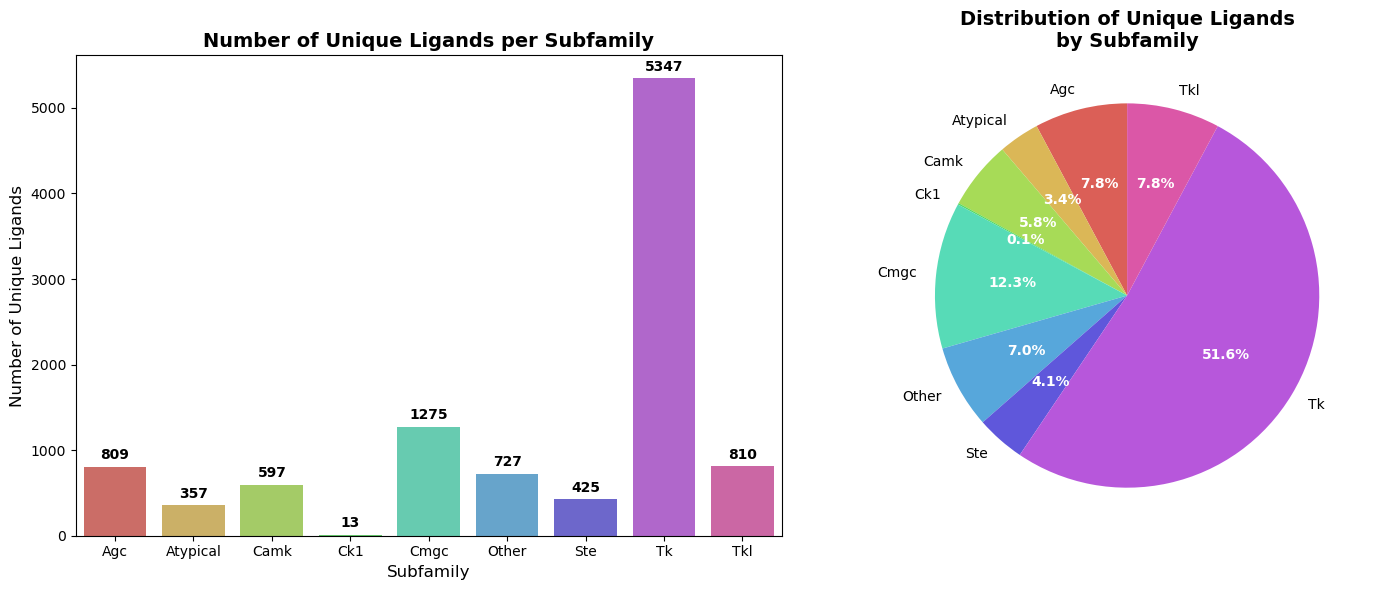

Summary of distribution:
shape: (9, 2)
┌────────────┬────────────────┐
│ short_name ┆ unique_ligands │
│ ---        ┆ ---            │
│ str        ┆ u32            │
╞════════════╪════════════════╡
│ Agc        ┆ 809            │
│ Atypical   ┆ 357            │
│ Camk       ┆ 597            │
│ Ck1        ┆ 13             │
│ Cmgc       ┆ 1275           │
│ Other      ┆ 727            │
│ Ste        ┆ 425            │
│ Tk         ┆ 5347           │
│ Tkl        ┆ 810            │
└────────────┴────────────────┘
Average unique_ligands per short_name: 1151.1


In [30]:
bar_title = 'Number of Unique Ligands per Subfamily'
pie_title = 'Distribution of Unique Ligands\nby Subfamily'
x = "short_name"
y = "unique_ligands"
xlabel = 'Subfamily'
ylabel = "Number of Unique Ligands"
# Calculate unique ligands per family cluster
ligand_counts = (cluster_df
                .group_by('short_name')
                .agg(pl.col('molregno').n_unique().alias('unique_ligands'))
                .sort('short_name'))
pie_bar_plot(ligand_counts, x, y, bar_title, pie_title, xlabel, ylabel)

In [35]:
target_df = pl.read_csv("/home/jack/unm_gra/data/LAA/Homosapiens-SINGLEPROTEIN-1100/targets/target_info.tsv", separator="\t")
target_df = target_df.join(family_info_df, on="protein_class_id")

/tmp/ipykernel_97248/2170470282.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pl_counts, x=x, y=y, ax=ax1, palette=colors)


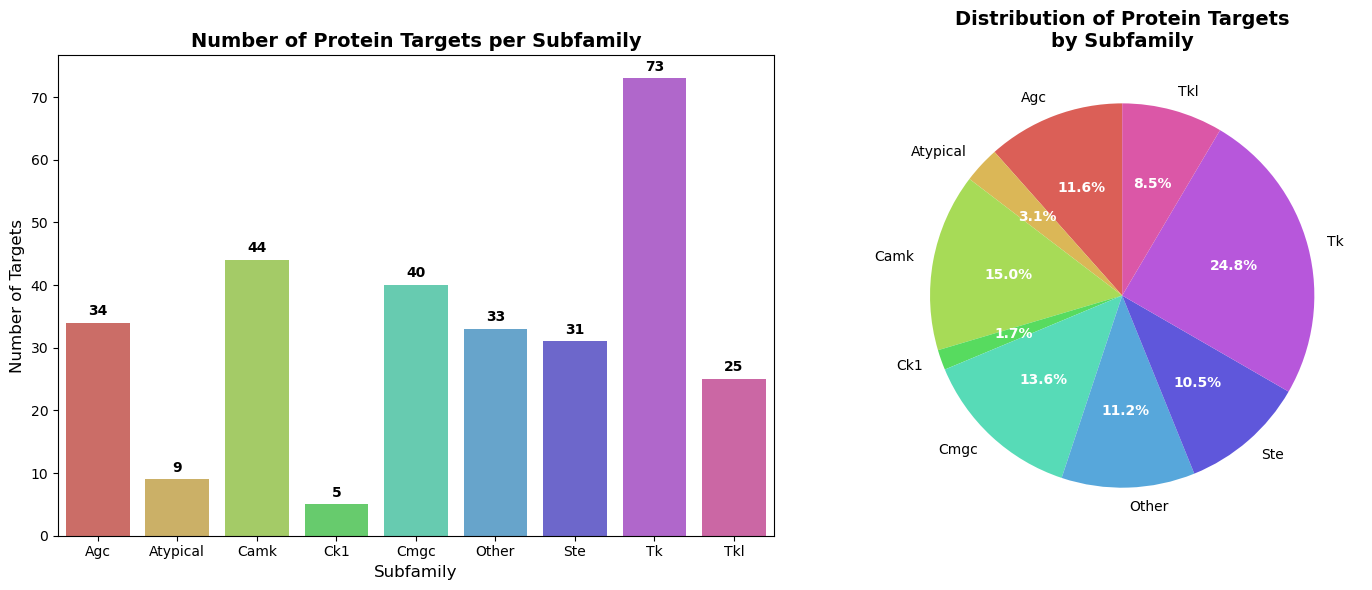

Summary of distribution:
shape: (9, 2)
┌────────────┬────────────┐
│ short_name ┆ unique_tid │
│ ---        ┆ ---        │
│ str        ┆ u32        │
╞════════════╪════════════╡
│ Agc        ┆ 34         │
│ Atypical   ┆ 9          │
│ Camk       ┆ 44         │
│ Ck1        ┆ 5          │
│ Cmgc       ┆ 40         │
│ Other      ┆ 33         │
│ Ste        ┆ 31         │
│ Tk         ┆ 73         │
│ Tkl        ┆ 25         │
└────────────┴────────────┘
Average unique_tid per short_name: 32.7


In [ ]:
# TODO: need to fix this - only includes targets w/ at least one active ligand
bar_title = "Number of Protein Targets per Subfamily"
pie_title = "Distribution of Protein Targets\nby Subfamily"
x = "short_name"
y = "unique_tid"
xlabel = "Subfamily"
ylabel = "Number of Targets"
# Calculate unique ligands per family cluster
target_counts = (cluster_df
                .group_by(x)
                .agg(pl.col('tid').n_unique().alias('unique_tid'))
                .sort(x))
pie_bar_plot(target_counts, x, y, bar_title, pie_title, xlabel, ylabel)

In [32]:
sum(target_counts["unique_tid"])

294